# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

## Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None) # служебная строка для печати всех столбцов таблицы на экран
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns

In [2]:
try:
    df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    df = pd.read_csv('C:\\python\\real_estate_data.csv', sep='\t')

**Выведем первые 20 строчек датафрейма**

In [3]:
df.head(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Вводим переменную old_size для того, чтобы после удаления пропусков и аномалий посчитать отношение нового размера датафрейма к старому.

In [4]:
old_size = df.shape[0]  # сохраняем размер датафрейма до изменений

**Выведем основную информацию о датафрейме с помощью метода info()**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Приведем название столбца 'cityCenters_nearest' к "змеиному" регистру, переименовав в 'distance_to_center'**

In [6]:
df = df.rename(columns={'cityCenters_nearest':'distance_to_center'})

**Построим гистограмму для всех числовых столбцов таблицы на одном графике**

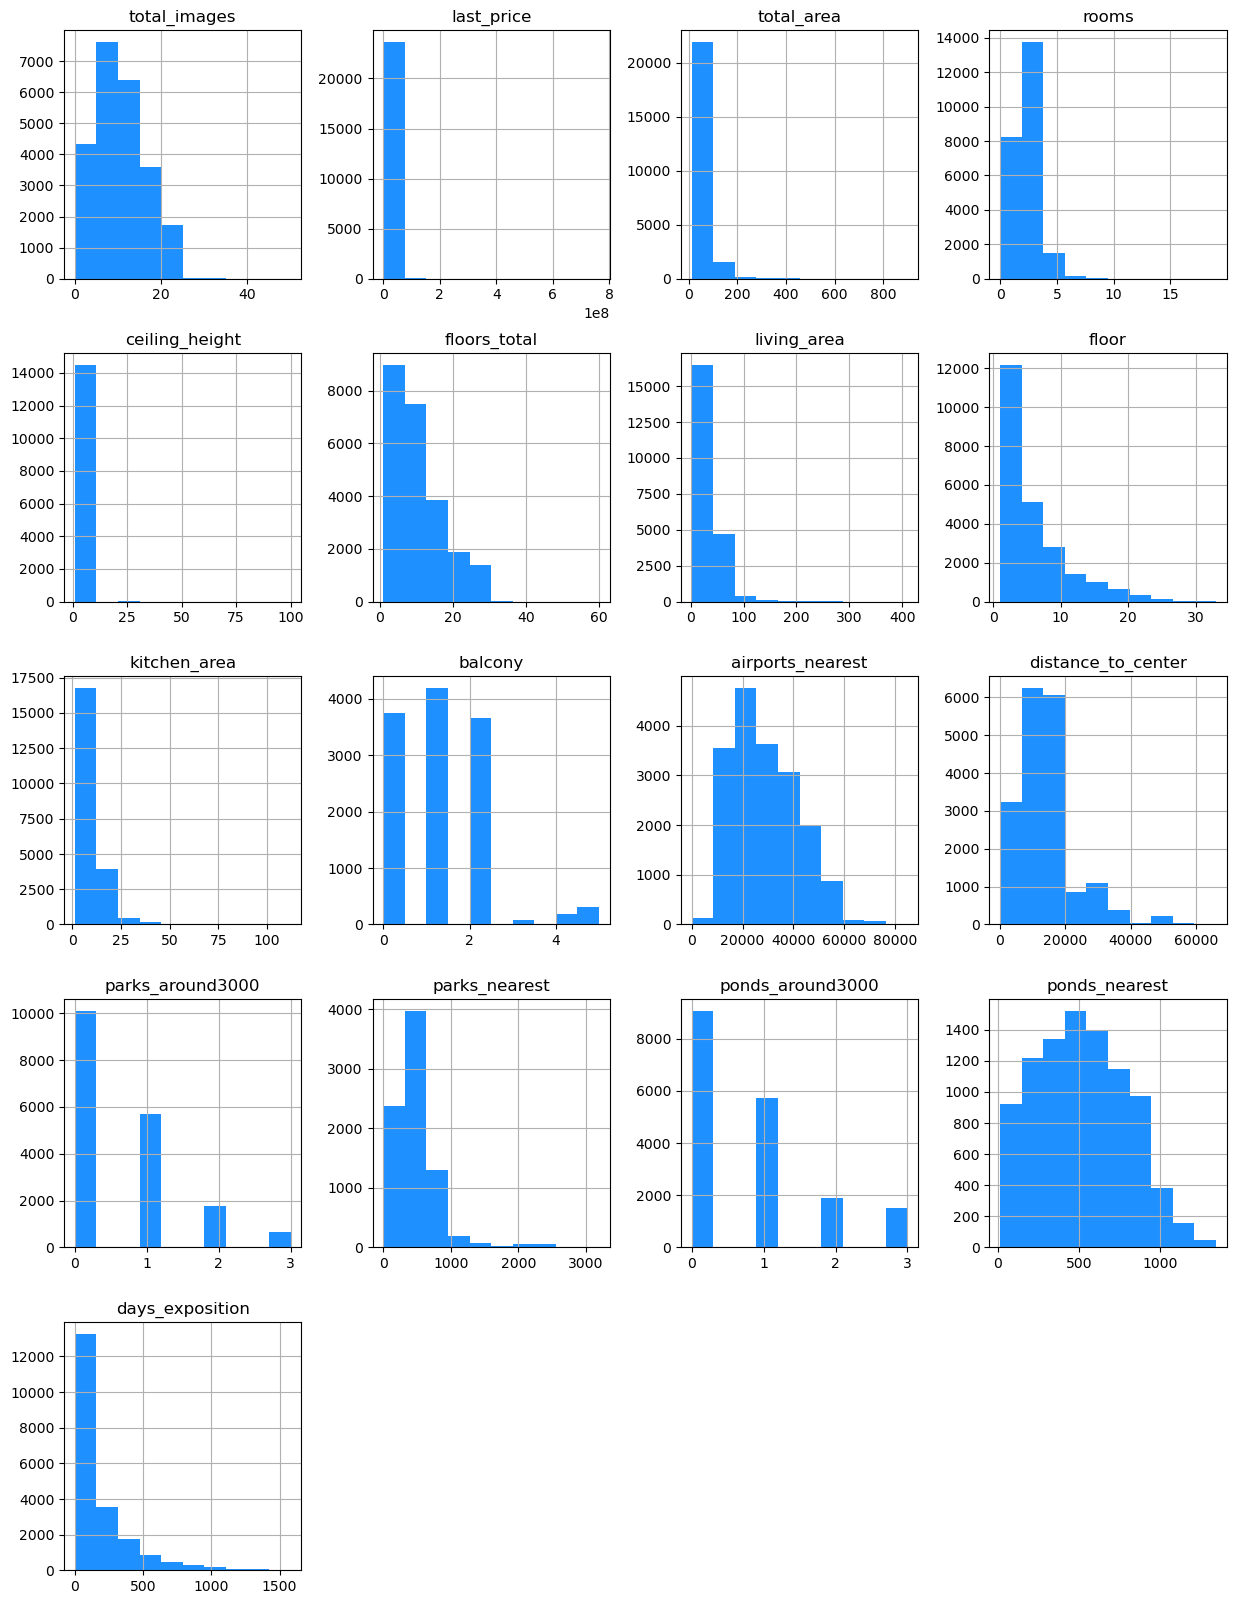

In [7]:
df.hist(figsize=(15, 20), color='dodgerblue');

### Описание данных

**Для исследования нам предоставлены данные о продажах квартир в Санкт-Петербурге за 6 лет — с 2014 по 2019 годы. Данные содержат 23699 строк в 22 столбцах:**
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

- balcony — число балконов

- ceiling_height — высота потолков (м)

- cityCenters_nearest — расстояние до центра города (м)

- days_exposition — сколько дней было размещено объявление (от публикации до снятия)

- first_day_exposition — дата публикации

- floor — этаж

- floors_total — всего этажей в доме

- is_apartment — апартаменты (булев тип)

- kitchen_area — площадь кухни в квадратных метрах (м²)

- last_price — цена на момент снятия с публикации

- living_area — жилая площадь в квадратных метрах (м²)

- locality_name — название населённого пункта

- open_plan — свободная планировка (булев тип)

- parks_around3000 — число парков в радиусе 3 км

- parks_nearest — расстояние до ближайшего парка (м)

- ponds_around3000 — число водоёмов в радиусе 3 км

- ponds_nearest — расстояние до ближайшего водоёма (м)

- rooms — число комнат

- studio — квартира-студия (булев тип)

- total_area — общая площадь квартиры в квадратных метрах (м²)

- total_images — число фотографий квартиры в объявлении

**В 14 столбцах есть пропуски. По ходу работы над проектом мы более подробно познакомимся с данными, рассмотрим каждый столблец, в котором есть пропущенные значения: часть пропусковмы заполним, часть оставим без изменений. Также обработаем, где возможно, аномальные значения. Пропуски в данных могут появиться вследствие человеческого или технического фактора. Например, при создании объявления о продаже квартиры пользователь оставил поле "апартаменты" или "количество балконов" пустым, так как квартира не является апартаментами или не имеет балконов. Также возможны ошибки или частичная утрата данных при выгрузке. Большое количество пропусков в столбцах, заполняемых автоматически на основе данных геосервисов, могут появиться вследвие некорректной работы последних.**

## Предобработка данных

### Удаление пропусков

**Выведем количество пропущенных значений для каждого столбца**

In [8]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
distance_to_center       5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Пропуски есть в 14 столбцах:**

**По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Пропуски в следующих столбцах могли появиться в связи с тем, что пользователи не указали в объявлении соответствующую информацию. 
Пропуски в столбце с количеством балконов, вероятно, означают, что балкона в квартире нет. Заменим пропущенные значения на 0. Далее заполним пропуски в следующих столбцах:** 

- balcony                 11519

- is_apartment            20924

- ceiling_height           9195

- living_area              1903

- kitchen_area             2278

**Пропуски в столбце floors_total оставим без изменений, их всего 86, погоды они не сыграют.**

**Пропуски в следующих столбцах относятся в другому виду данных — полученных автоматически на основе картографических данных. Такие данные как расстояние до ближайшего аэропорта, центра и других объектов, количество парков и водоёмов — автоматически получены из геосервисов. Пропуски в соответствующих объявлениях могут быть связаны с большой удаленностью от объектов, отсутствием данных или ошибками при обработке и выгрузке данных. Оставим пропуски в следующих столбцах без изменений:**

- locality_name              49

- distance_to_center      5519

- parks_around3000         5518

- parks_nearest           15620

- ponds_around3000         5518

- ponds_nearest           14589

- days_exposition          3181

- airports_nearest         5542


**Посмотрим, какие значения есть в столбце с количеством балконов**

In [9]:
df['balcony'].value_counts()

balcony
1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: count, dtype: int64

**Заполним пропуски нулями и изменим тип данных столбца на int64**

In [10]:
df['balcony'] = df['balcony'].fillna(0) 
df['balcony'] = df['balcony'].astype('int64')

**Изучим информацию о столбце is_apartment**

In [11]:
df['is_apartment'].value_counts()

is_apartment
False    2725
True       50
Name: count, dtype: int64

**Видим, что апартаментами являются только 50 объектов на продажу. Количество незаполненных строк в столбце is_apartment более 20000. Логично предположить, что такое большое количество объектов не может быть апартаментами. Заполним пропуски значением False.**

In [12]:
df['is_apartment'] = df['is_apartment'].fillna(False)

**Посмотрим уникальные значения в столбце ceiling_height** (количество пропусков — 9195)

In [13]:
np.sort(df['ceiling_height'].unique())

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

**В столбце наблюдаем выбросы: значения высоты потолков 100 метров, 20-32 метра, 14, 10, а также значения менее 2 метров. Вероятно, при заполнении или выгрузке данных были допущены ошибки, вследствие которых появились значения более 20 метров. Эти значения исправим путем деления на 10. Строки, в которых указана высота потолков больше 7 метров и строки, в которых потолки ниже 2 метров, удалим.** 

In [14]:
df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] = df.loc[df['ceiling_height'] >= 20, 'ceiling_height'] / 10

In [15]:
df = df[(df['ceiling_height'] < 1) | (df['ceiling_height'] >= 2) | df['ceiling_height'].isna()]

In [16]:
df = df[(df['ceiling_height'] < 7) | df['ceiling_height'].isna()]

**В центре Санкт-Петербурга сохранилось много зданий дореволюционной постройки, а также так называемые "сталинки". Дома современной постройки, находящиеся в центре города или недалеко от него, будут относиться к премиальному классу жилья, поэтому потолки там тоже высокие. Рассмотрим корреляцию отдаленности квартиры от центра и высоты потолков.**

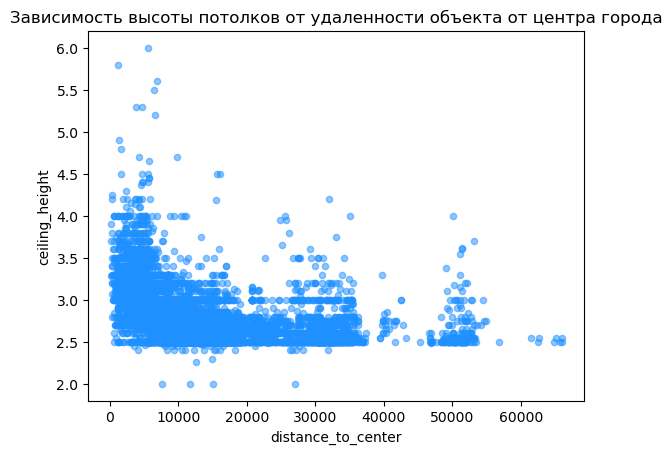

In [17]:
df['ceiling_height'].corr(df['distance_to_center'])
df.plot(x='distance_to_center', y='ceiling_height', kind='scatter', 
        title='Зависимость высоты потолков от удаленности объекта от центра города', color='dodgerblue', alpha=0.5); 

**Наблюдаем уменьшение высоты потолков по мере удаления от центра города. С помощью функции категоризируем объекты по расстоянию до центра и заполним пропуски. На графике видно, что имеется небольшое количество выбросов (значения 4,5-6 метров), поэтому для заполнения пропусков используем медиану, так как она более устойчива к аномальным значениям.**

**Выделим категории следующим образом:**

- 0-2км от центра — 'самый центр';
- 2-5км от центра — 'центр';
- 5-17км от центра — 'в пределах города';
- более 17км от центра — 'область'.

In [18]:
def categorize_distance(distance):
    try:
        if distance < 2000:
            return 'самый центр'
        if distance < 5000:
            return 'центр'
        if distance <= 17000:
            return 'в пределах города'
        if distance > 17000:
            return 'область'
    except:
        pass        

In [19]:
df['center_remoteness_cat'] = df['distance_to_center'].apply(categorize_distance) # применим функцию

**Посмотрим, что получилось:**

In [20]:
df[['locality_name','distance_to_center','center_remoteness_cat']].head(10)

,locality_name,distance_to_center,center_remoteness_cat
0,Санкт-Петербург,16028.0,в пределах города
1,посёлок Шушары,18603.0,область
2,Санкт-Петербург,13933.0,в пределах города
3,Санкт-Петербург,6800.0,в пределах города
4,Санкт-Петербург,8098.0,в пределах города
5,городской посёлок Янино-1,NaN,None
6,посёлок Парголово,19143.0,область
7,Санкт-Петербург,11634.0,в пределах города
8,посёлок Мурино,NaN,None
9,Санкт-Петербург,15008.0,в пределах города


**В функции мы прописали except-pass, поэтому объектам с пропущенным расстоянием до центра категория не присвоится — некоторое количество пропусков в столбце "высота потолка" все же останется. Заполним пропуски в столбце ceiling_height медианным значением по категории отдаленности от центра.**

In [21]:
for c in df['center_remoteness_cat'].unique():
    df.loc[(df['center_remoteness_cat'] == c) & (df['ceiling_height'].isna()), 'ceiling_height'] = \
    df.loc[(df['center_remoteness_cat'] == c), 'ceiling_height'].median()


**Посмотрим, сколько осталось пропусков:**

In [22]:
df['ceiling_height'].isna().sum()

2575

**И распределение высоты потолков по удаленности от центра:**

In [23]:
df.groupby('center_remoteness_cat')['ceiling_height'].mean().sort_values(ascending=False)

center_remoteness_cat
самый центр          3.221982
центр                3.134084
в пределах города    2.684620
область              2.631434
Name: ceiling_height, dtype: float64

**Уже лучше. Оставшиеся пропуски оставим без изменений. Посмотрим столбец "площадь кухни":**

- kitchen_area 2278

In [24]:
np.sort(df['kitchen_area'].unique())

array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.04,
         5.06,   5.1 ,   5.14,   5.2 ,   5.21,   5.23,   5.25,   5.28,
         5.29,   5.3 ,   5.31,   5.33,   5.35,   5.4 ,   5.42,   5.44,
         5.47,   5.49,   5.5 ,   5.53,   5.59,   5.6 ,   5.61,   5.62,
         5.64,   5.65,   5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,
         5.82,   5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,
         6.1 ,   6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,
         6.26,   6.27,   6.28,   6.3 ,   6.31,   6.33,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
         7.  ,   7.02,   7.03,   7.06,   7.09,   7.1 ,   7.12,   7.15,
      

**Посмотрим, указана ли площадь кухни в объявлениях о продаже квартир-студий:**

In [25]:
studio = df[df['studio'] == True]
print('Количество пропусков в объявлениях о продаже студий:', studio['kitchen_area'].isnull().sum())

Количество пропусков в объявлениях о продаже студий: 149


**Заполним нулями**

In [26]:
df.loc[(df['studio'] == True) & (df['kitchen_area'].isna()), 'kitchen_area'] = 0

**Посмотрим корреляцию и построим матрицу рассеяния, чтобы проследить взаимосвязь площади кухни, общей площади и жилой площади объекта**

,kitchen_area,living_area,total_area
kitchen_area,1.000000,0.431657,0.611988
living_area,0.431657,1.000000,0.939536
total_area,0.611988,0.939536,1.000000


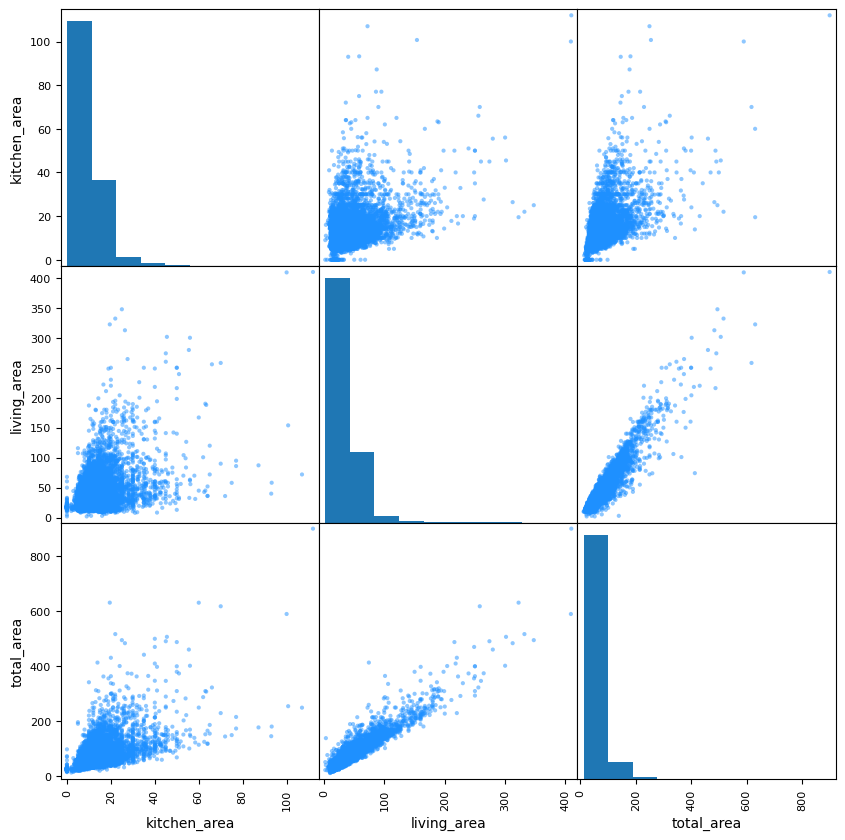

In [27]:
pd.plotting.scatter_matrix(df[['kitchen_area', 'living_area', 'total_area']], figsize=(10,10), color='dodgerblue', alpha=0.5)
df[['kitchen_area', 'living_area', 'total_area']].corr()

**Видим на графике, что с ростом общей и жилой площади квартиры также увеличивается и площадь кухни. Корреляция площади кухни и жилой площади составляет 0,4, а корреляция площади кухни и общей площади составляет 0,6. Используем эту зависимость для заполнения пропусков в столбце kitchen_area: как и в прошлый раз, категоризируем объекты по общей площади и заполним пропуски в столбце kitchen_area средним значением. 
Также на матрице видим высокую корреляцию общей и жилой площади — ее значение составляет 0,9. Используем это для заполнения пропусков в столбце living_area.**

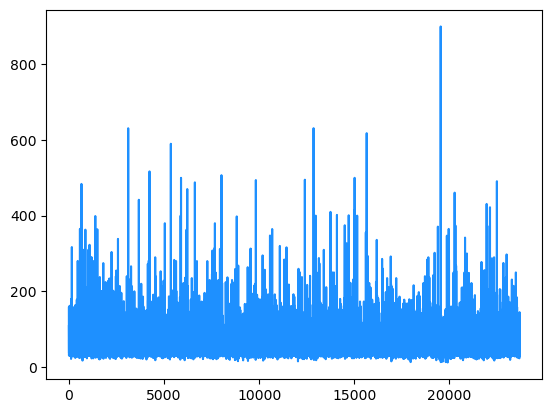

In [28]:
df['total_area'].plot(color='dodgerblue');

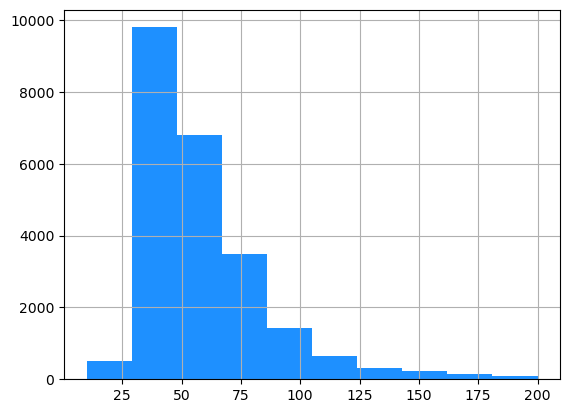

In [29]:
df['total_area'].hist(range=(10,200), color='dodgerblue');

**Видим на графиках, что площади квартир варьируются от 10 до 800 квадратных метров. Для удобства разделим объекты на категории:**
- до 25 квадратных метров;
- от 25 до 50 квадратных метров;
- от 50 до 100 квадратных метров;
- от 100 до 200 квадратных метров;
- больше 200 квадратных метров. 

In [30]:
def categorize_total_area(total_area):
    try:
        if total_area < 50:
            return 'до 50 м.кв.'
        if total_area < 100:
            return 'от 50 до 100 м.кв.'
        if total_area <= 200:
            return 'от 100 до 200 м.кв.'
        if total_area > 200:
            return 'больше 200 м.кв.'
    except:
        pass   

**Добавим столбец total_area_cat, применив к данным функцию categorize_total_area**

In [31]:
df['total_area_cat'] = df['total_area'].apply(categorize_total_area)

**Посмотрим распределение и среднюю площадь по каждой категории.**

In [32]:
df['total_area_cat'].value_counts().sort_values(ascending=False) # сколько квартир в каждой категории

total_area_cat
до 50 м.кв.            10929
от 50 до 100 м.кв.     10852
от 100 до 200 м.кв.     1681
больше 200 м.кв.         227
Name: count, dtype: int64

In [33]:
df.groupby('total_area_cat')['total_area'].mean().sort_values(ascending=False) # средняя площадь квартиры в категории

total_area_cat
больше 200 м.кв.       284.609648
от 100 до 200 м.кв.    128.258370
от 50 до 100 м.кв.      67.001460
до 50 м.кв.             38.652569
Name: total_area, dtype: float64

**Заполняем пропуски в столбце "площадь кухни" средним значением нового столбца**

In [34]:
for a in df['total_area_cat'].unique():
    df.loc[(df['total_area_cat'] == a) & (df['kitchen_area'].isna()), 'kitchen_area'] = \
    df.loc[(df['total_area_cat'] == a), 'kitchen_area'].mean()

**Посмотрим среднюю площадь кухни по каждой категории:**

In [35]:
df.groupby('total_area_cat')['kitchen_area'].mean().sort_values(ascending=False)

total_area_cat
больше 200 м.кв.       30.195202
от 100 до 200 м.кв.    19.320247
от 50 до 100 м.кв.     10.813332
до 50 м.кв.             8.402151
Name: kitchen_area, dtype: float64

**Аналогичным образом заполним пропуски в столбце living_area — средним значением по категории**

In [36]:
for liv in df['total_area_cat'].unique():
    df.loc[(df['total_area_cat'] == liv) & (df['living_area'].isna()), 'living_area'] = \
    df.loc[(df['total_area_cat'] == liv), 'living_area'].mean()

**Посмотрим распределение средней жилой площади по каждой категории:**

In [37]:
df.groupby('total_area_cat')['living_area'].mean().sort_values(ascending=False)

total_area_cat
больше 200 м.кв.       165.196935
от 100 до 200 м.кв.     74.362840
от 50 до 100 м.кв.      39.673711
до 50 м.кв.             20.675578
Name: living_area, dtype: float64

### Изменение типов данных

**Изменим тип данных в следующих столбцах:**

- floors_total, parks_around3000, ponds_around3000, days_exposition с float64 на int64

- first_day_exposition с object64 на datetime64 для удобства дальнейшей работы с данными этого столбца

- living_area и kitchen_area тип данных оставим без изменений, но преобразуем до значения с 1 знаком после запятой

- last_price итоговую цену переведем в тысячи для более удобного восприятия

- airports_nearest и distance_to_center переведем в километры, приведем к типу данных int64 


In [38]:
df[['airports_nearest', 'distance_to_center', 'last_price']] = df[['airports_nearest', 'distance_to_center', 'last_price']] / 1000

In [39]:
to_int_list = ['last_price', 'floors_total', 'parks_around3000', 'ponds_around3000', 'days_exposition', 'airports_nearest', 'distance_to_center']
  
try:
    for column in to_int_list:
        df[column] = df[df[column].notnull()][column].astype('int64')
except:
    pass

In [40]:
df[['living_area', 'total_area', 'kitchen_area']] = df[['living_area', 'total_area', 'kitchen_area']].round(1)

In [41]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'])

In [42]:
df.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,distance_to_center,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,center_remoteness_cat,total_area_cat
0,20,13000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18.0,16.0,1.0,482.0,2.0,755.0,NaN,в пределах города,от 100 до 200 м.кв.
1,7,3350,40.4,2018-12-04,1,2.60,11.0,18.6,1,False,False,False,11.0,2,посёлок Шушары,12.0,18.0,0.0,NaN,0.0,NaN,81.0,область,до 50 м.кв.
2,10,5196,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21.0,13.0,1.0,90.0,2.0,574.0,558.0,в пределах города,от 50 до 100 м.кв.
3,0,64900,159.0,2015-07-24,3,2.65,14.0,74.4,9,False,False,False,19.3,0,Санкт-Петербург,28.0,6.0,2.0,84.0,3.0,234.0,424.0,в пределах города,от 100 до 200 м.кв.
4,2,10000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31.0,8.0,2.0,112.0,1.0,48.0,121.0,в пределах города,от 100 до 200 м.кв.
5,10,2890,30.4,2018-09-10,1,NaN,12.0,14.4,5,False,False,False,9.1,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,None,до 50 м.кв.
6,6,3700,37.3,2017-11-02,1,2.60,26.0,10.6,6,False,False,False,14.4,1,посёлок Парголово,52.0,19.0,0.0,NaN,0.0,NaN,155.0,область,до 50 м.кв.
7,5,7915,71.6,2019-04-18,2,2.65,24.0,39.7,22,False,False,False,18.9,2,Санкт-Петербург,23.0,11.0,0.0,NaN,0.0,NaN,NaN,в пределах города,от 50 до 100 м.кв.
8,20,2900,33.2,2018-05-23,1,NaN,27.0,15.4,26,False,False,False,8.8,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,None,до 50 м.кв.
9,18,5400,61.0,2017-02-26,3,2.50,9.0,43.6,7,False,False,False,6.5,2,Санкт-Петербург,50.0,15.0,0.0,NaN,0.0,NaN,289.0,в пределах города,от 50 до 100 м.кв.


### Устранение неявных дубликатов

**Проверим наличие строк-дубликатов:**

In [43]:
df.duplicated().sum()

0

Явных дубликатов нет, едем дальше.

**Просмотрим уникальные значения столбца locality_name для поиска и устранения неявных дубликатов:**

In [44]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [45]:
df['locality_name'] = df['locality_name'].str.replace('ё', 'е')

df['locality_name'] = df['locality_name'].apply(lambda x: re.sub(r'^(деревня|село|поселок городского типа|городской поселок|коттеджный поселок|\
                                                                 поселок станции|поселок при железнодорожной станции|поселок|садовое товарищество|\
                                                                 садоводческое некоммерческое товарищество)\s', '', str(x)))

# Проверка результата
df['locality_name'].unique()


array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

### Добавление в таблицу новых столбцов


**Цена одного квадратного метра**

In [46]:
df.loc[:, 'meter2_price'] = round((df['last_price'] / df['total_area']), 2)

**День недели публикации объявления (0 — понедельник, 1 — вторник и так далее)**

In [47]:
df.loc[:, 'day_of_exposition'] = df['first_day_exposition'].dt.weekday

**Месяц публикации объявления**

In [48]:
df.loc[:, 'month_of_exposition'] = df['first_day_exposition'].dt.month

**Год публикации объявления**

In [49]:
df.loc[:, 'year_of_exposition'] = df['first_day_exposition'].dt.year
np.sort(df['year_of_exposition'].unique())

array([2014, 2015, 2016, 2017, 2018, 2019])

**Тип этажа квартиры (значения — «первый», «последний», «другой»)**

In [50]:
np.sort(df['floors_total'].unique())

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 52., 60., nan])

60 этажей — неожиданный результат. Пока оставим так для добавления столбца, позже обработаем аномальные значения. Создадим функцию:

In [51]:
try:
    def categorize_floor(row):
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
except: 
    pass

In [52]:
df['floor_type'] = df.apply(categorize_floor, axis=1) # применяем функцию к датафрейму

**Посмотрим на результат:**

In [53]:
df[['meter2_price', 'day_of_exposition', 'month_of_exposition', 'year_of_exposition', 'floor_type']].head()

,meter2_price,day_of_exposition,month_of_exposition,year_of_exposition,floor_type
0,120.37,3,3,2019,другой
1,82.92,1,12,2018,первый
2,92.79,3,8,2015,другой
3,408.18,4,7,2015,другой
4,100.00,1,6,2018,другой


### Вывод

**Как мы увидели, данные достаточно загрязнены:**
- ошибками (высота потолков записана в целочисленном формате вместо вещественного, что привело к появлению квартир с потолками высотой 20-30 метров);

- пропусками, как в данных, предоставляемых пользователями, так и в данных, заполняемых автоматически;

- неявными дубликатами в столбце 'locality_name': имеются повторяющиеся названия населенных пунктов: «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» и так далее;

- несоответствием форматов.

**В ходе предварительной обработки были выполнены следующие действия:**
1. Обработаны пропуски в столбцах

- balcony заменены на 0

- is_apartment заменены на False

- ceiling_height произведена категоризация объектов по удаленности от центра города, пропуски заполнены медианным значением по категории

- living_area и kitchen_area заполнены средним значением по категории "общая площадь" в связи с высокой корреляцией данных показателей

2. Изменили тип и представление данных в следующих столбцах:

- floors_total, parks_around3000, ponds_around3000, days_exposition с float64 на int64

- first_day_exposition с object64 на datetime64 для удобства дальнейшей работы с данными этого столбца

- living_area и kitchen_area преобразовали до значения с 1 знаком после запятой

- last_price итоговую цену перевели в тысячи для более удобного восприятия

- airports_nearest и distance_to_center перевели в километры, привели к типу данных int64 

3. Добавили в талицу новые столбцы:

- meter2_price средняя цена за квадратный метр

- day_of_exposition	день недели, когда было размещено объявление

- month_of_exposition месяц публикации объявления

- year_of_exposition год публикации объявления

- floor_type тип этажа квартиры (первый, последний, другой)

**Теперь данные готовы для дальнейшего анализа.**

## Исследовательский анализ данных

**В этом блоке изучим перечисленные ниже параметры объектов. По возможности удалим аномалии. 
Список параметров:**
- общая площадь;
- жилая площадь;
- площадь кухни;
- цена объекта;
- количество комнат;
- высота потолков;
- тип этажа квартиры («первый», «последний», «другой»);
- общее количество этажей в доме;
- расстояние до центра города в метрах;
- расстояние до ближайшего парка**

**Изучим, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.
Посмотрим, сколько времени обычно занимает продажа: какие продажи можно считать быстрыми, а какие — необычно долгими?
Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.
Изучим, зависит ли цена от:**
- общей площади;
- жилой площади;
- площади кухни;
- количества комнат;
- этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).**

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.**

**Ранее мы посчитали расстояние до центра в километрах. Теперь вычислим среднюю стоимость квартир на разном удалении от центра Санкт-Петербурга. Опишем, как стоимость объектов зависит от расстояния до центра города.**

### Изучаем данные на предмет наличия аномальных значений

**Изучим данные столбцов 'total_area', 'living_area', 'kitchen_area', 'last_price' и построим диаграмму размаха.**

In [54]:
df[['total_area', 'living_area', 'kitchen_area', 'last_price']].describe()

,total_area,living_area,kitchen_area,last_price
count,23689.000000,23689.000000,23689.000000,23689.000000
mean,60.354684,34.575381,10.489565,6541.951285
std,35.659543,22.029889,5.777797,10889.044091
min,12.000000,2.000000,0.000000,12.000000
25%,40.000000,19.000000,7.200000,3400.000000
50%,52.000000,30.000000,9.000000,4650.000000
75%,69.900000,42.000000,11.600000,6800.000000
max,900.000000,409.700000,112.000000,763000.000000


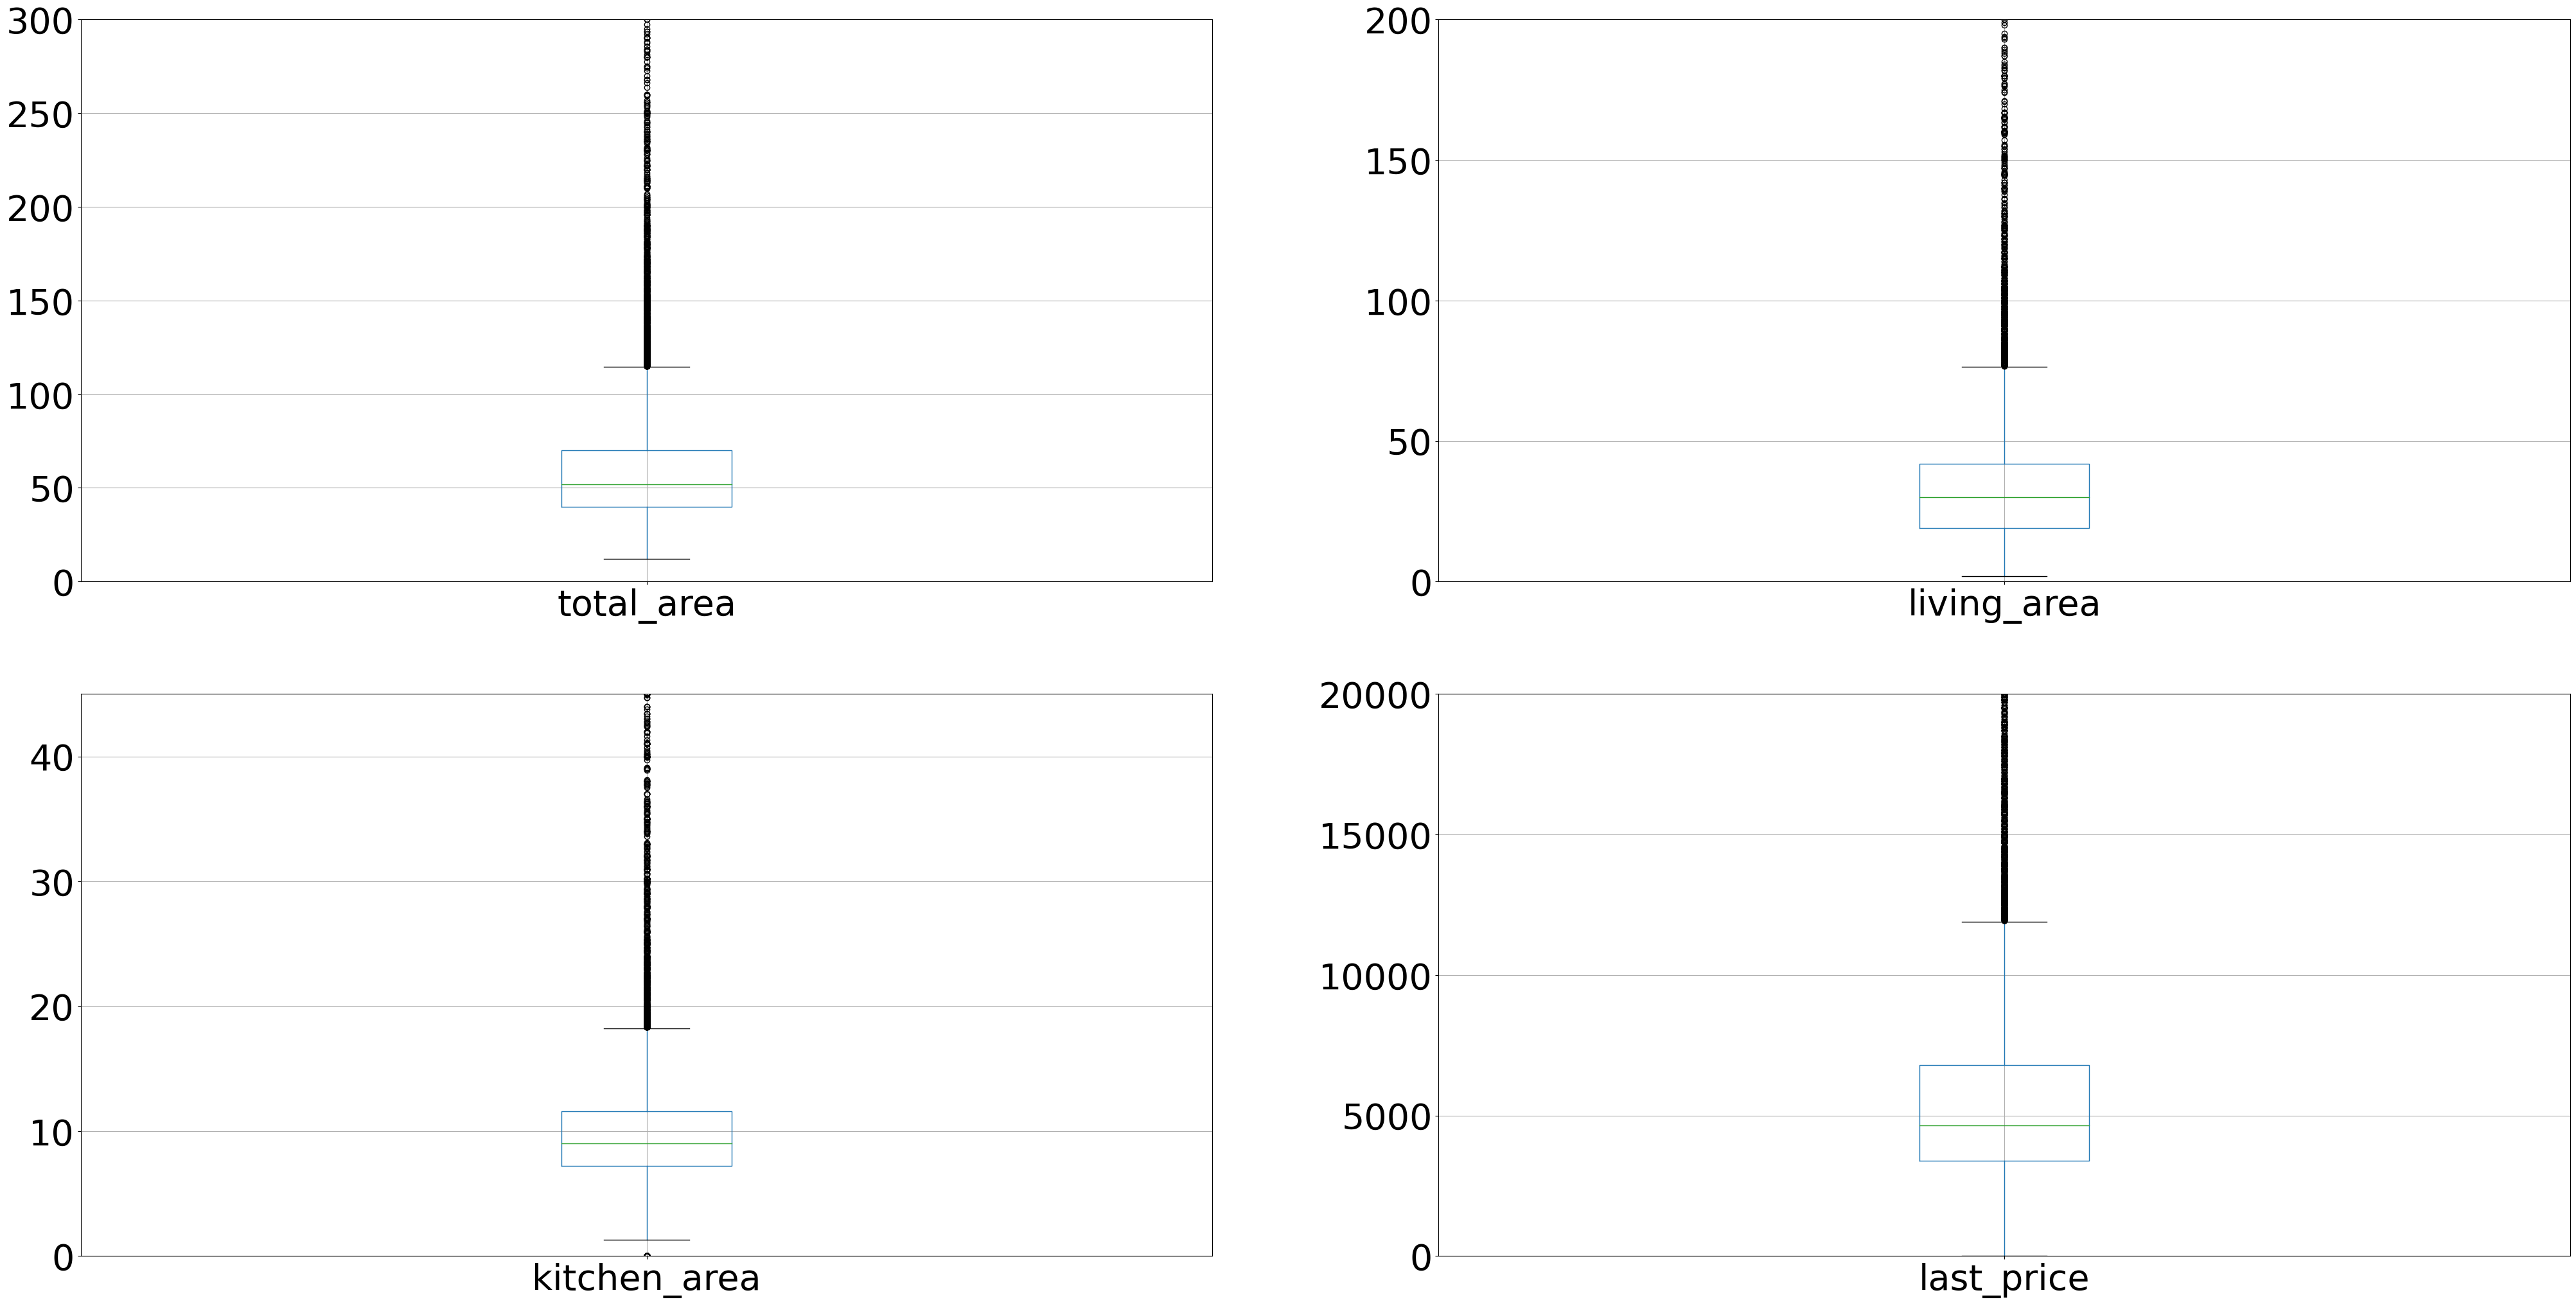

In [55]:
rows = 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(50,25))
column_list = ['total_area', 'living_area', 'kitchen_area', 'last_price']
ylims = [300, 200, 45, 20000]
count = 0
for r in range(rows):
    for c in range(cols):
        ax = df.boxplot(column=column_list[count], ax=axes[r,c], fontsize=40)
        ax.set_ylim([0, ylims[count]])
        count += 1

**Значения распределяются следующим образом:**
- 'total_area' — в размах "усов" падает метраж от 12 до 120 м.кв. Имеется большое количество выбросов — квартиры общей площадью 300-600 кв.метров и даже больше. Например, максимальное значение, полученное при вызове метода decsribe выдало такой результат: общая площадь 900.000000, жилая площадь 409.700000, площадь кухни 112.000000, стоимость	763000.000000. Посмотрим, какое в данных количество квартир общей площадью более 300 м.кв.
- 'living_area' — нормальные значения находятся в диапазоне от 2 до 75 м.кв. 
- 'kitchen_area' — нормальные значения в диапазоне от 1 до 18 м.кв. Также встречаются значения 0 — это квартиры-студии.
- 'last_price' — нормальные значения находятся в диапазоне от 0 до 12 млн.ед.

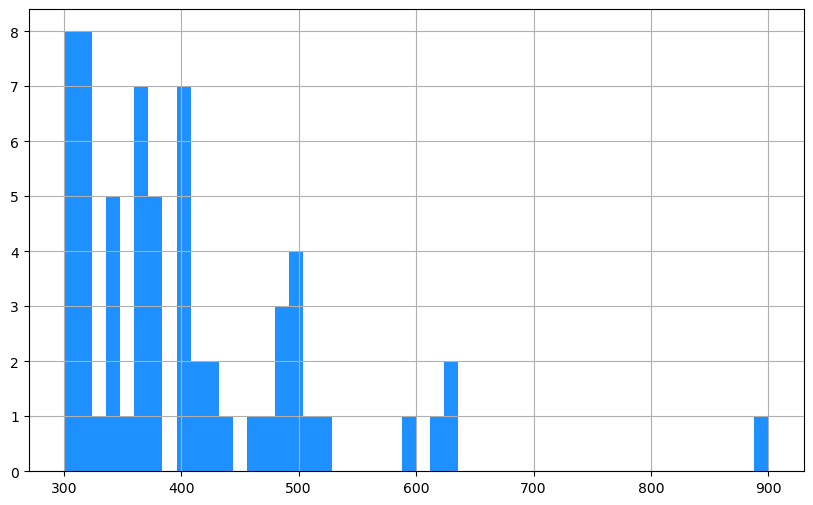

In [56]:
df['total_area'].hist(figsize=(10,6), range=(300,900), bins=50, color='dodgerblue');

**На гистограмме видно, что в представленной выборке имеется небольшое количество квартир общей площадью 300-400 м.кв. (около 40), 400-500 м.кв (примерно 15 таких квартир), 4 квартиры площадью более 600 м.кв. Аномалии могут существенно влиять на среднее значение и стандартное отклонение в наборе данных, что может привести к неверным прогнозам или выводам. Удалим строки с квартирами общей площадью более 300 м.кв., чтобы избежать искажения результатов анализа. Посмотрим на выбросы в столбце last_price.**

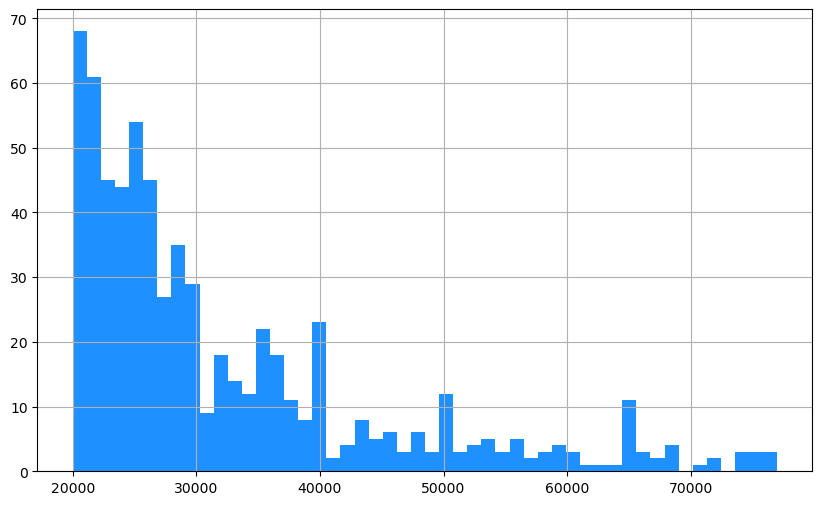

In [57]:
df['last_price'].hist(figsize=(10,6), range=(20000,77000), bins=50, color='dodgerblue');

**В данных имеются квартиры стоимостью 20-30 млн.ед. (примерно 300 таких), 30-40 млн.ед. — порядка 150 квартир и дороже 40 млн. — 182 квартиры. Для более точного анализа оставим объявления о квартирах стоимостью до 20 млн., и еще удалим строку, в которой  указана стоимость 12 тысяч.**

**Дальше посмотрим столбцы 'rooms' и'ceiling_height'. Ранее мы обработали аномальные значения в столбце с высотой потолка.**

In [58]:
df[['rooms', 'ceiling_height']].describe()

,rooms,ceiling_height
count,23689.000000,21114.000000
mean,2.070835,2.713950
std,1.078503,0.246056
min,0.000000,2.000000
25%,1.000000,2.600000
50%,2.000000,2.650000
75%,3.000000,2.750000
max,19.000000,6.000000


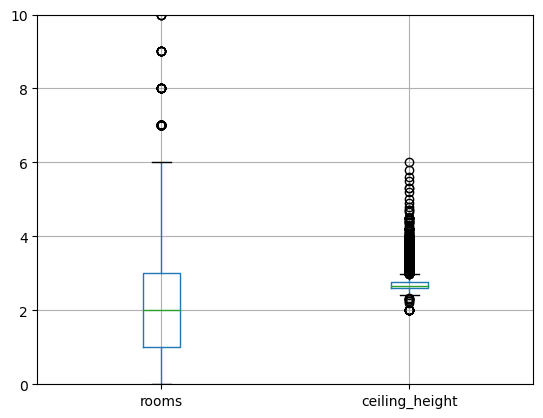

In [59]:
plt.ylim(0, 10)
df[['rooms', 'ceiling_height']].boxplot();

**Наблюдаем:**
- 'rooms' нормальные значения от 0 до 6 комнат, максимальное значение 19. 
- 'ceiling_height' — нормальные значения в диапазоне от 2,6 до 2,75 м. Встречаются значения меньше (2-2,5 метра) и больше — до 6 м.

In [60]:
len(df[df['rooms'] > 6]) 

90

**Общее количество квартир, в которых больше 6 комнат — 90. Удалим их, чтобы не искажали результаты анализа.**

In [61]:
df = df[(df['last_price'] > 100) & (df['last_price'] < 20000) & (df['total_area'] < 300) & (df['rooms'] < 6)]        

Посмотрим отношение нового размера к старому, чтобы узнать, как изменился размер датафрейма.

In [62]:
new_size = df.shape[0]
round((new_size / old_size)*100, 2)

96.53

В пределах допустимых значений. Можно продолжать.

**Посмотрим распределение типов этажа квартиры («первый», «последний», «другой»)**

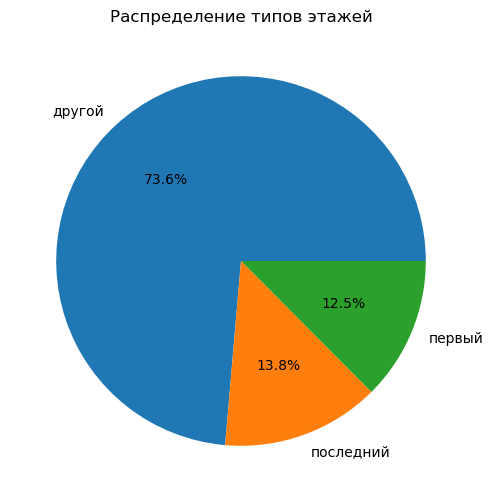

In [63]:
floor_count = df['floor_type'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(floor_count, labels=floor_count.index, autopct='%1.1f%%')
plt.title('Распределение типов этажей')
plt.show()

**12,5 % квартир находятся на 1 этаже, 13,8 % — на последнем. Большая часть объектов (73,6 %) располагается на других этажах.**

**Посмотрим распределение общего количества этажей в доме**

In [64]:
df['floors_total'].describe()

count    22794.000000
mean        10.755988
std          6.634251
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

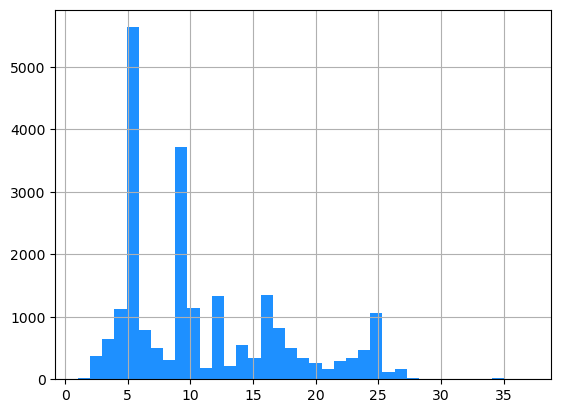

In [65]:
df['floors_total'].hist(range=(1,37), bins=37, color='dodgerblue');

**Большинство квартир находятся в пятиэтажных домах, на втором месте — девятиэтажки. Дальше идут 16-ти и 25-этажные дома. Самый высокий дом в Санкт-Петербурге в ЖК Князь Александр Невский — 37 этажей. удалим строки с количеством этажей больше 37.**

In [66]:
df = df[(df['floors_total'] < 37) | df['floors_total'].isna()]

**Расстояние до центра города в метрах**

In [67]:
df[['distance_to_center', 'parks_nearest']].describe()

,distance_to_center,parks_nearest
count,17376.000000,7493.000000
mean,14.044890,494.664487
std,8.565734,342.996713
min,0.000000,1.000000
25%,9.000000,290.000000
50%,13.000000,457.000000
75%,16.000000,616.000000
max,65.000000,3190.000000


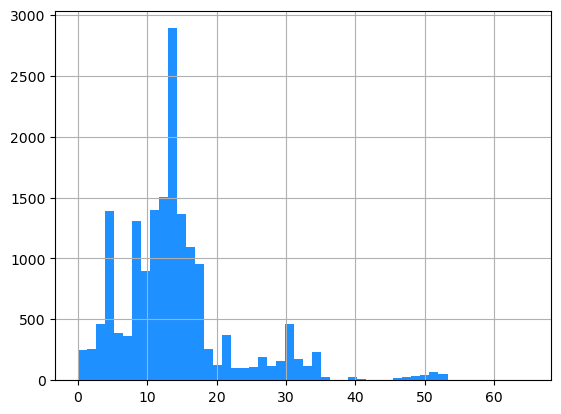

In [68]:
df['distance_to_center'].hist(bins=50, color='dodgerblue');

**Значения расстояния до центра в диапазоне от 180 м до 66 км. Больше всего квартир находятся на расстоянии от 10 до 20 км от центра Санкт-Петербурга.**

In [69]:
df[df['distance_to_center'] < 0.2]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,distance_to_center,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,center_remoteness_cat,total_area_cat,meter2_price,day_of_exposition,month_of_exposition,year_of_exposition,floor_type
1104,0,7970,63.0,2018-02-09,3,3.20,5.0,35.0,3,False,False,False,10.0,0,Санкт-Петербург,21.0,0.0,2.0,278.0,3.0,265.0,15.0,самый центр,от 50 до 100 м.кв.,126.51,4,2,2018,другой
1182,1,5800,33.6,2016-03-10,1,3.70,7.0,22.8,4,False,False,False,6.6,0,Санкт-Петербург,21.0,0.0,3.0,304.0,3.0,503.0,167.0,самый центр,до 50 м.кв.,172.62,3,3,2016,другой
1335,14,6450,82.0,2015-10-31,2,3.20,4.0,40.5,3,False,False,False,22.4,0,Санкт-Петербург,21.0,0.0,2.0,194.0,3.0,135.0,532.0,самый центр,от 50 до 100 м.кв.,78.66,5,10,2015,другой
1351,14,8500,66.2,2019-02-27,3,3.01,4.0,37.4,4,False,False,False,9.4,1,Санкт-Петербург,20.0,0.0,0.0,NaN,2.0,243.0,NaN,самый центр,от 50 до 100 м.кв.,128.40,2,2,2019,последний
1876,12,11490,74.0,2016-08-31,3,2.70,5.0,45.4,5,False,False,False,9.8,1,Санкт-Петербург,20.0,0.0,3.0,333.0,2.0,29.0,469.0,самый центр,от 50 до 100 м.кв.,155.27,2,8,2016,последний
1934,18,9590,108.0,2017-05-23,2,3.30,5.0,59.0,2,False,False,False,11.0,0,Санкт-Петербург,21.0,0.0,3.0,359.0,3.0,290.0,69.0,самый центр,от 100 до 200 м.кв.,88.80,1,5,2017,другой
2326,1,8500,125.0,2017-09-28,4,3.50,6.0,95.0,3,False,False,False,8.0,0,Санкт-Петербург,20.0,0.0,0.0,NaN,2.0,251.0,12.0,самый центр,от 100 до 200 м.кв.,68.00,3,9,2017,другой
2478,1,4000,39.0,2018-02-08,2,3.10,5.0,25.9,1,False,False,False,5.4,0,Санкт-Петербург,22.0,0.0,1.0,888.0,2.0,134.0,4.0,самый центр,до 50 м.кв.,102.56,3,2,2018,первый
2609,20,7200,80.0,2017-08-24,3,2.80,4.0,43.0,1,False,False,False,8.0,0,Санкт-Петербург,21.0,0.0,3.0,415.0,2.0,516.0,11.0,самый центр,от 50 до 100 м.кв.,90.00,3,8,2017,первый
2744,5,10000,100.4,2018-07-10,3,3.50,4.0,55.0,4,False,False,False,15.0,0,Санкт-Петербург,20.0,0.0,3.0,480.0,2.0,145.0,268.0,самый центр,от 100 до 200 м.кв.,99.60,1,7,2018,последний


**Вполне правдоподобно, можно оставить. Дальше посмотрим расстояние до ближайшего парка**

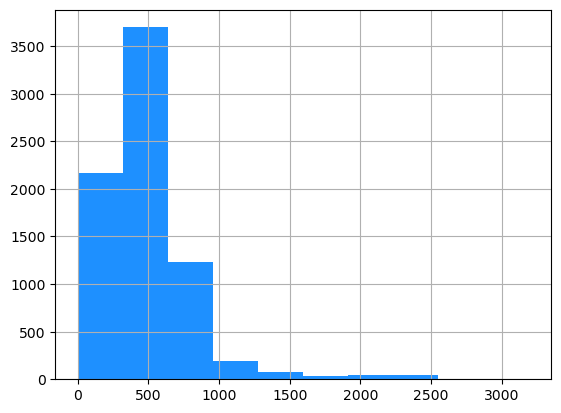

In [70]:
df['parks_nearest'].hist(color='dodgerblue');

**Если в радиусе 3000 метров от квартиры есть парк, то чаще всего он в радиусе 1000 метров. Похоже, что данные, заполняемые автоматически с помощью геосервиса, заполнены корректно (без выбросов), за исключением пропусков.**

### Анализ времени продажи квартир (столбец days_exposition)

**Построим гистограмму, чтобы посмотреть за сколько дней продавались квартиры.**

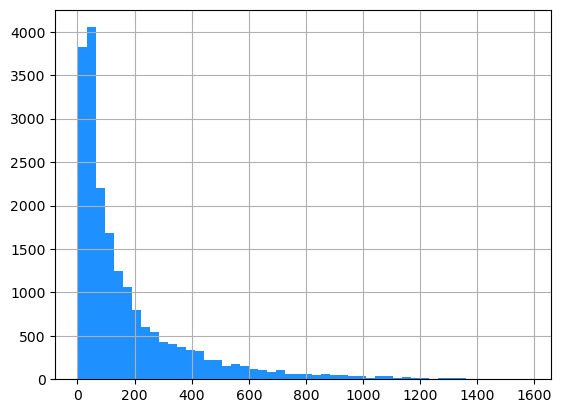

In [71]:
df['days_exposition'].hist(bins=50, color='dodgerblue');

**Более 4000 квартир были проданы меньше, чем за 100 дней. После отметки 100 идет резкий спуск и хвост гистограммы. Посмотрим поближе на пиковые значения.**

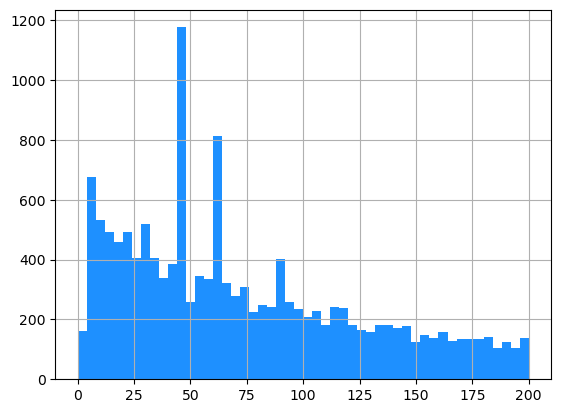

In [72]:
df['days_exposition'].hist(range=(0,200), bins=50, color='dodgerblue');

**На гистограмме видим пики в районе 45 и 60 дней, небольшой пик в районе 85; устойчивое равномерное снижение числа продаж с 5 до 200 дня с момента размещения объявления. По правилам Яндекс.Недвижимости объявления автоматически снимаются с публикции как раз на 45й и 60й день, в зависимости от типа. Посмотрим среднее и медиану.**

In [73]:
df['days_exposition'].mean()

177.5199016212418

In [74]:
df['days_exposition'].median()

93.0

In [75]:
df['days_exposition'].describe()

count    19923.000000
mean       177.519902
std        216.170227
min          1.000000
25%         44.000000
50%         93.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Среднее время продажи составляет примерно 181 день. Однако стандартное отклонение достаточно велико (220 дней), что указывает на значительное разнообразие в данных.**

Быстрые продажи: Если мы рассмотрим первый квартиль, то увидим, что 25% всех продаж были совершены за 44 дней или меньше.

Средние продажи: Медианное значение составляет 93 дней. Это означает, что половина всех продаж была совершена за 93 дней или меньше.

Необычно долгие продажи: Если мы рассмотрим третий квартиль, то увидим, что 75% всех продаж были совершены за 226 дней или меньше. Продажи, которые занимают больше времени, можно считать необычно долгими.

Максимальное значение в данных составляет 1580 дней, что является очень долгим временем для продажи. Однако это максимальное значение, и такие случаи скорее исключение, чем правило.

### Изучение зависимости цены объекта от различных факторов. 

**Чтобы узнать, зависит ли цена от: общей площади; жилой площади; площади кухни; количества комнат; этажа, на котором расположена квартира (первый, последний, другой); даты размещения (день недели, месяц, год), построим матрицу рассеяния.**

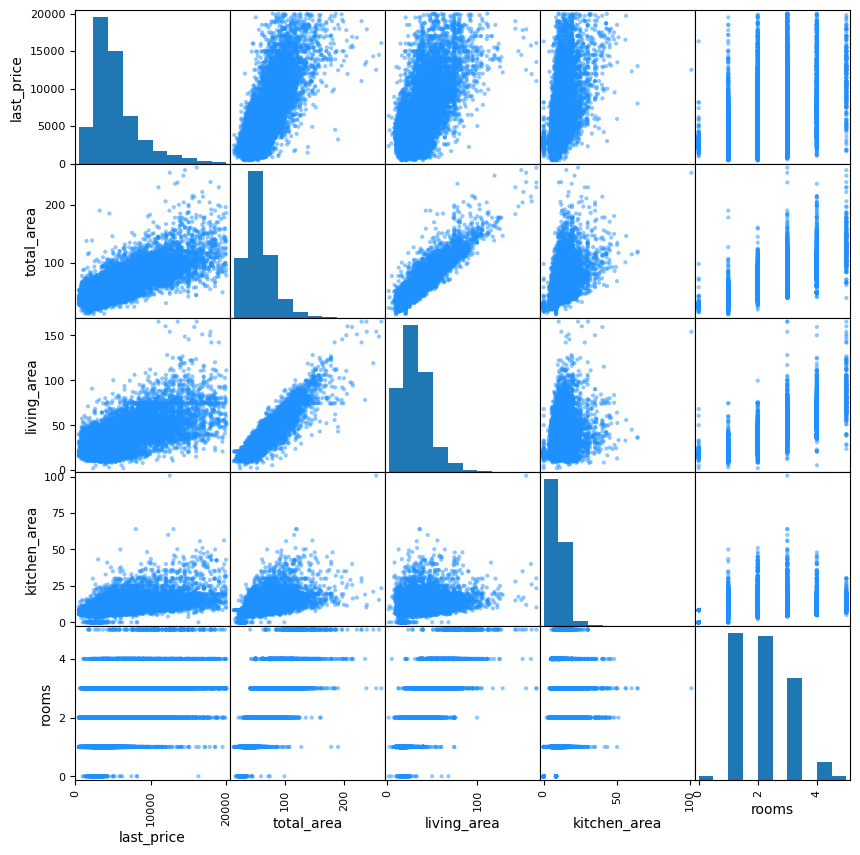

In [76]:
columns = ['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms']
df_matrix = df[columns]
pd.plotting.scatter_matrix(df_matrix, figsize=(10,10), color='dodgerblue');

In [77]:
df[['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms']].corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.768847,0.654992,0.571151,0.491333
total_area,0.768847,1.000000,0.917634,0.542285,0.784720
living_area,0.654992,0.917634,1.000000,0.312777,0.858195
kitchen_area,0.571151,0.542285,0.312777,1.000000,0.193552
rooms,0.491333,0.784720,0.858195,0.193552,1.000000


**Проанализируем взаимосвязи:**
- total_area: Коэффициент корреляции составляет 0.768, что указывает на сильную положительную взаимосвязь. Это означает, что с увеличением общей площади, цена на недвижимость также, как правило, увеличивается.
- living_area: Коэффициент корреляции составляет 0.654, что также указывает на положительную взаимосвязь, хотя и не такую сильную, как с total_area. Это означает, что с увеличением жилой площади, цена на недвижимость обычно также увеличивается.
- kitchen_area: Коэффициент корреляции составляет 0.571, что указывает на умеренную положительную взаимосвязь. Это означает, что с увеличением площади кухни, цена на недвижимость обычно также увеличивается, хотя эта связь не такая сильная, как с total_area или living_area.
- rooms: Коэффициент корреляции составляет 0.491, что указывает на слабую положительную взаимосвязь. Это означает, что с увеличением количества комнат, цена на недвижимость обычно также увеличивается, но эта связь слабее, чем с другими признаками.

**Изучим зависимость стоимости квартиры от дня, месяца и года публикации объявления.**

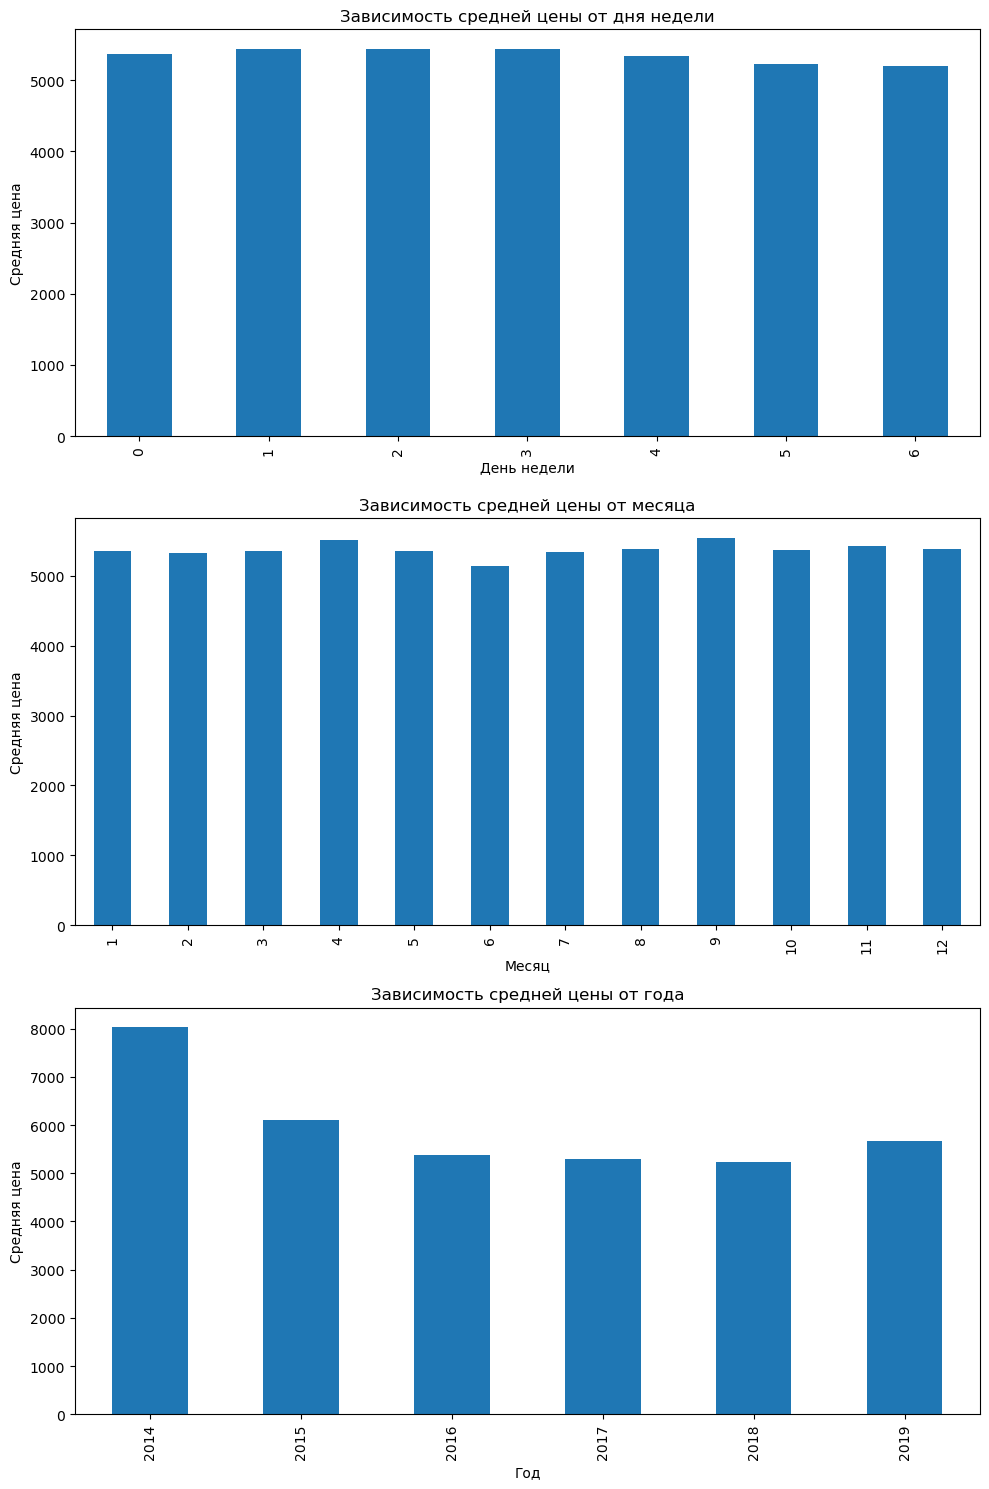

In [78]:
# columns = ['last_price', 'day_of_exposition', 'month_of_exposition', 'year_of_exposition']

mean_price_per_day = df.groupby('day_of_exposition')['last_price'].mean()
mean_price_per_month = df.groupby('month_of_exposition')['last_price'].mean()
mean_price_per_year = df.groupby('year_of_exposition')['last_price'].mean()

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
mean_price_per_day.plot(kind='bar', ax=ax[0])
ax[0].set_title('Зависимость средней цены от дня недели')
ax[0].set_xlabel('День недели')
ax[0].set_ylabel('Средняя цена')

# График зависимости средней цены от месяца
mean_price_per_month.plot(kind='bar', ax=ax[1])
ax[1].set_title('Зависимость средней цены от месяца')
ax[1].set_xlabel('Месяц')
ax[1].set_ylabel('Средняя цена')

# График зависимости средней цены от года
mean_price_per_year.plot(kind='bar', ax=ax[2])
ax[2].set_title('Зависимость средней цены от года')
ax[2].set_xlabel('Год')
ax[2].set_ylabel('Средняя цена')

plt.tight_layout()
plt.show()

**Итак:**
- стоимость квартиры от дня недели публикации практически никак не зависит;
- зависимость цены от месяца публикации: цены на квартиры, чьи объявления о продаже были опубликованы в апреле и сентябре, немного выше, чем по остальным месяцам;
- зависимость цены от года публикации — в 2014 году цены на квартиры были самые высокие, в 2015-2017 годах можно наблюдать плавное снижение цен, в 2018 году цены на квартиры остаются примерно на том же уровне, а в 2019 году наблюдаем рост цен на недвижимость.


**Связь этажа и стоимости квартиры**

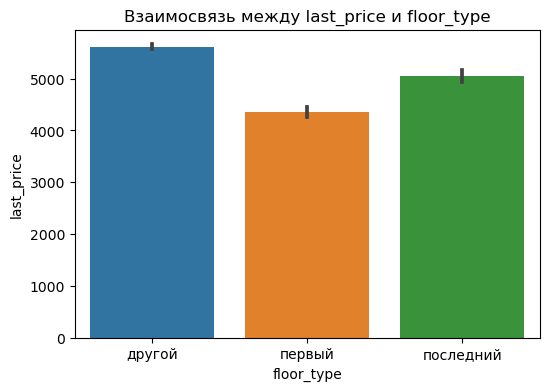

In [79]:
plt.figure(figsize=(6,4))
sns.barplot(x='floor_type', y='last_price', data=df)

plt.title('Взаимосвязь между last_price и floor_type')
plt.show()

**Наблюдаем, что квартиры на последнем этаже самые дорогие, немного  меньше стоят квартиры на остальных этажах и самые низкие цены на квартиры, находящиеся на первом этаже.**

**Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений — построим сводную таблицу с количеством объявлений и средней ценой квадратного метра для этих населенных пунктов.**

In [80]:
grouped = df.groupby('locality_name').agg({'meter2_price': 'mean', 'locality_name': 'count'})
grouped.columns = ['Средняя стоимость квадратного метра', 'Количество объявлений']
top_10_localities = grouped.sort_values('Количество объявлений', ascending=False).head(10)
top_10_localities.sort_values('Средняя стоимость квадратного метра', ascending=False)

,Средняя стоимость квадратного метра,Количество объявлений
locality_name,,
Санкт-Петербург,108.689010,14925
Пушкин,101.876741,359
Кудрово,95.323136,472
Парголово,90.333773,326
Мурино,86.087153,590
Шушары,78.678136,440
Колпино,75.332789,337
Гатчина,68.746254,307
Всеволожск,67.213678,397


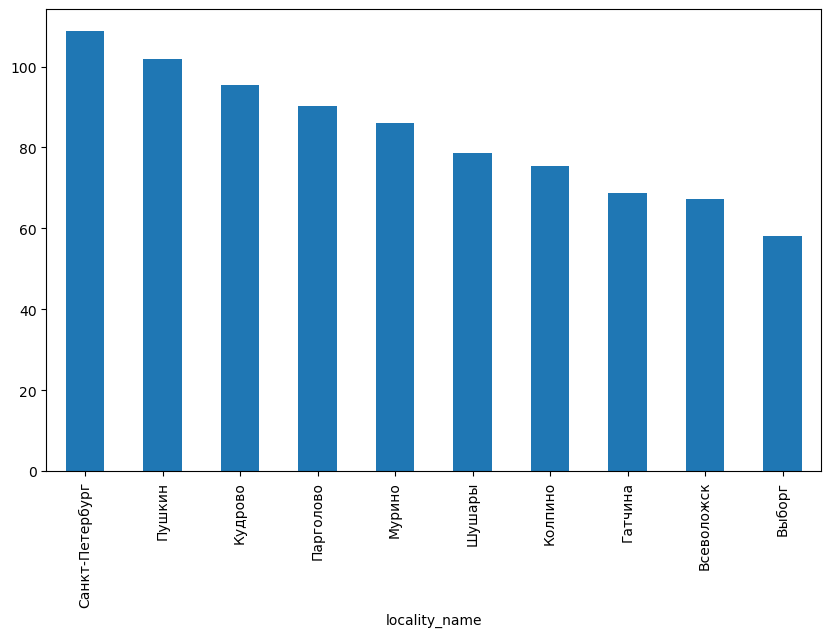

In [81]:
plt.figure(figsize=(10,6))
top_10_localities['Средняя стоимость квадратного метра'].sort_values(ascending=False).plot(kind='bar');

**Самая высокая стоимость квадратного метра в Санкт-Петербурге и Пушкине. Самая низкая цена за квадратный метр в Выборге и Всеволожске.**

Ранее мы посчитали расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра. 

In [82]:
center_price = df[df['locality_name'] == 'Санкт-Петербург']
center_price.loc[:, 'distance_to_center_km'] = np.round(center_price['distance_to_center'])
average_center_price = center_price.groupby('distance_to_center_km')['last_price'].mean().round(1)
average_center_price.columns = ['Расстояние до центра, км', 'Средняя стоимость']
average_center_price.head(10)

C:\Users\Галина\AppData\Local\Temp\ipykernel_7152\273347490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  center_price.loc[:, 'distance_to_center_km'] = np.round(center_price['distance_to_center'])


distance_to_center_km
0.0     9738.5
1.0    10098.5
2.0     9447.8
3.0     8877.0
4.0     9529.4
5.0     8683.2
6.0     8148.1
7.0     8005.2
8.0     7310.0
9.0     6018.8
Name: last_price, dtype: float64

**Посмотрим на графике, как изменяется средняя стоимость квартир по мере удаления от центра Санкт-Петербурга:**

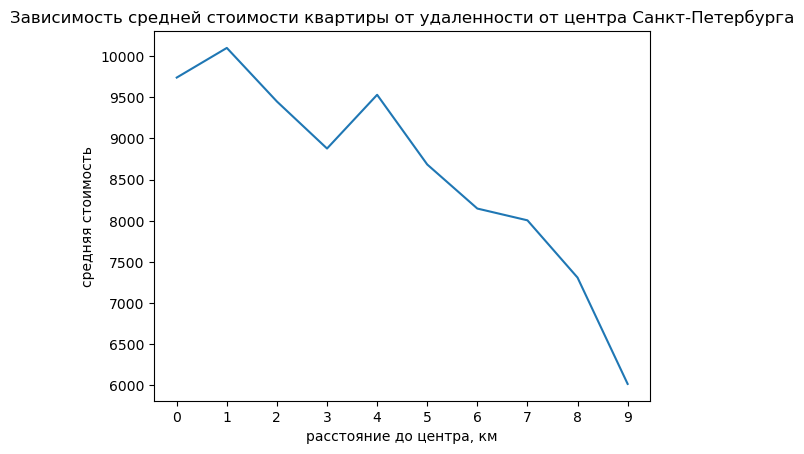

In [83]:
average_center_price_plt = average_center_price.head(10)
plt.title('Зависимость средней стоимости квартиры от удаленности от центра Санкт-Петербурга')
plt.xlabel('расстояние до центра, км')
plt.ylabel('средняя стоимость')
plt.xticks(np.arange(0, 10, step=1)) # изменим шаг на оси x 
plt.plot(average_center_price_plt);




**Из данных видно, что стоимость квартиры в Санкт-Петербурге зависит от расстояния до центра города:**

- квартиры, расположенные в центре города (0 км), имеют самую высокую среднюю стоимость, равную 31449.1.
- с увеличением расстояния до центра города средняя стоимость квартир уменьшается. Например, квартиры, расположенные на расстоянии 1 км от центра, имеют среднюю стоимость 10098.5, а квартиры на расстоянии 2 км -  9447.8.
- однако есть некоторые исключения из этого общего тренда. Например, средняя стоимость квартир, расположенных на расстоянии 4 км от центра (9529.4), выше, чем стоимость квартир на расстоянии 3 км (8877.0). Вероятно, это Василеостровский район дает такой показатель.
- квартиры, расположенные на расстоянии 9 км от центра, имеют самую низкую среднюю стоимость, равную 6018.8.

### Вывод

В этом блоке изучили перечисленные ниже параметры объектов. 
Значения распределяются следующим образом:

- 'total_area' — в размах "усов" падает метраж от 12 до 120 м.кв. Удалили строки со значениями выше 300 м.кв.
- 'living_area' — нормальные значения находятся в диапазоне от 2 до 75 м.кв.
- 'kitchen_area' — нормальные значения в диапазоне от 1 до 18 м.кв. Также встречаются значения 0 — это квартиры-студии.
- 'last_price' — нормальные значения находятся в диапазоне от 0 до 12 млн.ед. Квартиры стоимостью больше 20 млн.ед. удалили из выборки для более точного анализа. 
- 'rooms' нормальные значения от 0 до 6 комнат, максимальное значение 19. Удалили строки со значением выше 6
- 'ceiling_height' — нормальные значения в диапазоне от 2,6 до 2,75 м. 
- 'floor' — 12,5 % квартир находятся на 1 этаже, 13,8 % — на последнем. Большая часть объектов (73,6 %) располагается на других этажах.
- 'floors_total' — большинство квартир находятся в пятиэтажных домах, на втором месте — девятиэтажки. Дальше идут 16-ти и 25-этажные дома. Удалили аномальные значения в столбце.
- 'distance_to_center' — значения расстояния до центра в диапазоне от 180 м до 66 км. Больше всего квартир находятся на расстоянии от 10 до 20 км от центра Санкт-Петербурга.
- parks_nearest — если в радиусе 3000 метров от квартиры есть парк, то чаще всего он в радиусе 1000 метров. 

Изучили, как быстро продавались квартиры (столбец days_exposition). Среднее время продажи составляет примерно 181 день. Однако стандартное отклонение достаточно велико (220 дней), что указывает на значительное разнообразие в данных. Быстрые продажи: 25% всех продаж были совершены за 44 дней или меньше. Средние продажи: половина всех продаж была совершена за 93 дней или меньше. Необычно долгие продажи: 75% всех продаж были совершены за 226 дней или меньше. Продажи, которые занимают больше времени, можно считать необычно долгими. Максимальное значение в данных составляет 1580 дней, что является очень долгим временем для продажи. Однако это максимальное значение, и такие случаи скорее исключение, чем правило. 

Узнали, зависит ли цена от: общей площади; жилой площади; площади кухни; количества комнат; этажа, на котором расположена квартира (первый, последний, другой); даты размещения (день недели, месяц, год).

- total_area: Коэффициент корреляции составляет 0.768, что указывает на сильную положительную взаимосвязь. Это означает, что с увеличением общей площади, цена на недвижимость также, как правило, увеличивается.
- living_area: Коэффициент корреляции составляет 0.654, что также указывает на положительную взаимосвязь, хотя и не такую сильную, как с total_area. Это означает, что с увеличением жилой площади, цена на недвижимость обычно также увеличивается.
- kitchen_area: Коэффициент корреляции составляет 0.571, что указывает на умеренную положительную взаимосвязь. Это означает, что с увеличением площади кухни, цена на недвижимость обычно также увеличивается, хотя эта связь не такая сильная, как с total_area или living_area.
- rooms: Коэффициент корреляции составляет 0.491, что указывает на слабую положительную взаимосвязь. Это означает, что с увеличением количества комнат, цена на недвижимость обычно также увеличивается, но эта связь слабее, чем с другими признаками.

Изучили зависимость стоимости квартиры от дня, месяца и года публикации объявлени.

- стоимость квартиры от дня недели публикации практически никак не зависит;
- зависимость цены от месяца публикации: цены на квартиры, чьи объявления о продаже были опубликованы в апреле и сентябре, немного выше, чем по остальным месяцам;
- зависимость цены от года публикации — в 2014 году цены на квартиры были самые высокие, в 2015-2017 годах можно наблюдать плавное снижение цен, в 2018 году цены на квартиры остаются примерно на том же уровне, а в 2019 году наблюдаем рост цен на недвижимость.

Наблюдаем, что квартиры на последнем этаже самые дорогие, немного меньше стоят квартиры на остальных этажах и самые низкие цены на квартиры, находящиеся на первом этаже. 

Из данных видно, что стоимость квартиры в Санкт-Петербурге зависит от расстояния до центра города:

- квартиры, расположенные в центре города (0 км), имеют самую высокую среднюю стоимость, равную 31449.1.
- с увеличением расстояния до центра города средняя стоимость квартир уменьшается. Например, квартиры, расположенные на расстоянии 1 км от центра, имеют среднюю стоимость 10098.5, а квартиры на расстоянии 2 км -  9447.8.
- однако есть некоторые исключения из этого общего тренда. Например, средняя стоимость квартир, расположенных на расстоянии 4 км от центра (9529.4), выше, чем стоимость квартир на расстоянии 3 км (8877.0). Вероятно, это Василеостровский район дает такой показатель.
- квартиры, расположенные на расстоянии 9 км от центра, имеют самую низкую среднюю стоимость, равную 6018.8.

### Общий вывод

**Предварительная обработка данных**

Для исследования предоставлены данные о продажах квартир в Санкт-Петербурге за 6 лет — с 2014 по 2019 годы. Данные содержат 23699 строк в 22 столбцах:

- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)

- balcony — число балконов

- ceiling_height — высота потолков (м)

- cityCenters_nearest — расстояние до центра города (м)

- days_exposition — сколько дней было размещено объявление (от публикации до снятия)

- first_day_exposition — дата публикации

- floor — этаж

- floors_total — всего этажей в доме

- is_apartment — апартаменты (булев тип)

- kitchen_area — площадь кухни в квадратных метрах (м²)

- last_price — цена на момент снятия с публикации

- living_area — жилая площадь в квадратных метрах (м²)

- locality_name — название населённого пункта

- open_plan — свободная планировка (булев тип)

- parks_around3000 — число парков в радиусе 3 км

- parks_nearest — расстояние до ближайшего парка (м)

- ponds_around3000 — число водоёмов в радиусе 3 км

- ponds_nearest — расстояние до ближайшего водоёма (м)

- rooms — число комнат

- studio — квартира-студия (булев тип)

- total_area — общая площадь квартиры в квадратных метрах (м²)

- total_images — число фотографий квартиры в объявлении

В 14 столбцах были обнаружены пропуски. Пропуски в данных могут появиться вследствие человеческого или технического фактора. Например, при создании объявления о продаже квартиры пользователь оставил поле "апартаменты" или "количество балконов" пустым, так как квартира не является апартаментами или не имеет балконов. Также возможны ошибки или частичная утрата данных при выгрузке. Большое количество пропусков в столбцах, заполняемых автоматически на основе данных геосервисов, могут появиться вследвие некорректной работы последних.
Представленные данные достаточно загрязнены:

- ошибками (высота потолков записана в целочисленном формате вместо вещественного, что привело к появлению квартир с потолками высотой 20-30 метров);

- пропусками, как в данных, предоставляемых пользователями, так и в данных, заполняемых автоматически;

- неявными дубликатами в столбце 'locality_name': имеются повторяющиеся названия населенных пунктов: «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» и так далее;

- несоответствием форматов.

В ходе предварительной обработки были выполнены следующие действия:

Обработаны пропуски в столбцах
- balcony заменены на 0

- is_apartment заменены на False

- ceiling_height произведена категоризация объектов по удаленности от центра города, пропуски заполнены медианным значением по категории

- living_area и kitchen_area заполнены средним значением по категории "общая площадь" в связи с высокой корреляцией данных показателей.


Изменили тип и представление данных в следующих столбцах:

- floors_total, parks_around3000, ponds_around3000, days_exposition с float64 на int64

- first_day_exposition с object64 на datetime64 для удобства дальнейшей работы с данными этого столбца

- living_area и kitchen_area преобразовали до значения с 1 знаком после запятой

- last_price итоговую цену перевели в тысячи для более удобного восприятия

- airports_nearest и distance_to_center перевели в километры, привели к типу данных int64


**Проведен исследовательский анализ данных. Параметры объектов распределяются следующим образом:**

- 'total_area' — в размах "усов" падает метраж от 12 до 120 м.кв. Удалили строки со значениями выше 300 м.кв.
- 'living_area' — нормальные значения находятся в диапазоне от 2 до 75 м.кв.
- 'kitchen_area' — нормальные значения в диапазоне от 1 до 18 м.кв. Также встречаются значения 0 — это квартиры-студии.
- 'last_price' — нормальные значения находятся в диапазоне от 0 до 12 млн.ед. Квартиры стоимостью больше 20 млн.ед. удалили из выборки для более точного анализа. 
- 'rooms' нормальные значения от 0 до 6 комнат, максимальное значение 19 
- 'ceiling_height' — нормальные значения в диапазоне от 2,6 до 2,75 м. 
- 'floor' — 12,5 % квартир находятся на 1 этаже, 13,8 % — на последнем. Большая часть объектов (73,6 %) располагается на других этажах.
- 'floors_total' — большинство квартир находятся в пятиэтажных домах, на втором месте — девятиэтажки. Дальше идут 16-ти и 25-этажные дома. Удалили аномальные значения в столбце.
- 'distance_to_center' — значения расстояния до центра в диапазоне от 180 м до 66 км. Больше всего квартир находятся на расстоянии от 10 до 20 км от центра Санкт-Петербурга.
- parks_nearest — если в радиусе 3000 метров от квартиры есть парк, то чаще всего он в радиусе 1000 метров. 

Среднее время продажи составляет примерно 181 день. Однако стандартное отклонение достаточно велико (220 дней), что указывает на значительное разнообразие в данных. Быстрые продажи: 25% всех продаж были совершены за 44 дней или меньше. Средние продажи: половина всех продаж была совершена за 93 дней или меньше. Необычно долгие продажи: 75% всех продаж были совершены за 226 дней или меньше. Продажи, которые занимают больше времени, можно считать необычно долгими. Максимальное значение в данных составляет 1580 дней, что является очень долгим временем для продажи. Однако это максимальное значение, и такие случаи скорее исключение, чем правило. 

Взаимосвязь стоимости квартиры и различных параметров:

- total_area: Коэффициент корреляции составляет 0.768, что указывает на сильную положительную взаимосвязь. Это означает, что с увеличением общей площади, цена на недвижимость также, как правило, увеличивается.
- living_area: Коэффициент корреляции составляет 0.654, что также указывает на положительную взаимосвязь, хотя и не такую сильную, как с total_area. Это означает, что с увеличением жилой площади, цена на недвижимость обычно также увеличивается.
- kitchen_area: Коэффициент корреляции составляет 0.571, что указывает на умеренную положительную взаимосвязь. Это означает, что с увеличением площади кухни, цена на недвижимость обычно также увеличивается, хотя эта связь не такая сильная, как с total_area или living_area.
- rooms: Коэффициент корреляции составляет 0.491, что указывает на слабую положительную взаимосвязь. Это означает, что с увеличением количества комнат, цена на недвижимость обычно также увеличивается, но эта связь слабее, чем с другими признаками.

Изучили зависимость стоимости квартиры от дня, месяца и года публикации объявлени.

- стоимость квартиры от дня недели публикации практически никак не зависит;
- зависимость цены от месяца публикации: цены на квартиры, чьи объявления о продаже были опубликованы в апреле и сентябре, немного выше, чем по остальным месяцам;
- зависимость цены от года публикации — в 2014 году цены на квартиры были самые высокие, в 2015-2017 годах можно наблюдать плавное снижение цен, в 2018 году цены на квартиры остаются примерно на том же уровне, а в 2019 году наблюдаем рост цен на недвижимость.

Квартиры на последнем этаже самые дорогие, немного меньше стоят квартиры на остальных этажах и самые низкие цены на квартиры, находящиеся на первом этаже. 

Из данных видно, что стоимость квартиры в Санкт-Петербурге зависит от расстояния до центра города:

- квартиры, расположенные в центре города (0 км), имеют самую высокую среднюю стоимость, равную 31449.1.
- с увеличением расстояния до центра города средняя стоимость квартир уменьшается. Например, квартиры, расположенные на расстоянии 1 км от центра, имеют среднюю стоимость 10098.5, а квартиры на расстоянии 2 км -  9447.8.
- однако есть некоторые исключения из этого общего тренда. Например, средняя стоимость квартир, расположенных на расстоянии 4 км от центра (9529.4), выше, чем стоимость квартир на расстоянии 3 км (8877.0). Вероятно, это Василеостровский район дает такой показатель.
- квартиры, расположенные на расстоянии 9 км от центра, имеют самую низкую среднюю стоимость, равную 6018.8.

**Рекомендации по сбору данных**

Загрязненные данные усложняют работу и снижают точность анализа, поэтому для более качественного сбора данных рекомендуется:
- столбец locality_name заполнять не вручную, а выбирать наименование населенного пункта из выпадающего списка. Это решит проблему неявных дубликатов в столбце. 
- сделать некоторые поля обязательными для заполнения пользователем, например ceiling_height, либо предусмотреть автоматическое запонение нулями таких полей как kitchen_area и balcony.
- проверить функционирование геосервиса, чтобы в строках, заполняемых автоматически не было пропусков. 

